# Semantic Segmentation ด้วย U-Net 

Semantic Segmentation คือ จำแนกว่า Pixel หลายล้าน Pixel แต่ละจุด คืออะไร จะได้ผลออกมาเป็นแบ่งเป็นพื้นที่สีต่าง ๆ ซึ่งแต่ละสีหมายความถึงลักษณะที่แตกต่างกัน เช่น บ้าน, ถนน, ต้นไม้, etc. 

เปรียบเทียบกับ [Image Classification](https://www.bualabs.com/archives/530/machine-learning-ai-skin-disease-classification-custom-dataset-how-to-build-model-resnet50-deep-learning-python-image-classification-ep-4/) คือ การจำแนกรูปทั้งรูป และ Instance Segmetation คือ เหมือน Semantic Segmentaion แต่เพิ่มเติมคือสามารถบอกแยกแต่ละ Instance ของ Object ได้ เช่น แยกต้นไม้แต่ละต้นได้ด้วย ไม่ใช่ถมเป็นสีเดียวกันหมดว่าเป็นต้นไม้

จากที่สมัยก่อนที่จะมี Deep Learning การ Segmentation เราต้องทำ [Feature Engineering](https://www.bualabs.com/archives/1495/what-is-feature-engineering-machine-learning-rms-titanic-survival-prediction-deep-learning-tabular-data-ep-2/) แบ่งภาพตามเฉดสี, ตาม Contrast, ตามขอบ เราสามารถใช้ [Deep Neural Networks](https://www.bualabs.com/archives/1763/what-is-neural-network-how-neural-network-work-build-deep-neural-network-from-scratch-neural-network-ep-1/) มาเทรน End-to-End ได้เลย

# 0. Magic Commands


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

# 2. ข้อมูล

เราจะใช้ Dataset จาก Camvid: Motion-based Segmentation and Recognition Dataset Brostow et al., 2008 

The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation ปี 2016 ได้ Global Accuracy 91.5%

ls ดูว่าได้ไฟล์อะไรมาบ้าง 

* images เก็บรูป
* labels เก็บ label
* valid.txt เก็บรายการรูปที่เป็น Validation Set เนื่องจาก Dataset นี้เป็นการ Capture มาจากวิดีโอ เราต้องเลือก Validation Set ให้เป็นรูปที่ ช่วงเวลาไม่ต่อกันกับ Training Set ไม่งั้นจะง่ายเกินไป จนกลายเป็นจำข้อสอบ 
* codes.txt คือ รายการรหัสหมวดหมู่ทั้งหมด

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_labels = path/'labels'
path_images = path/'images'

ดึงรายชื่อไฟล์จาก path_images และแสดงรายการ 10 ไฟล์แรก

In [0]:
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_01680.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06630.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_009120.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08017.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_07991.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_007200.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f02010.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f00300.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_02250.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f00960.png')]

# Label เป็นรูปเหมือนกัน

label เป็นไฟล์รูปชื่อเดียวกับ images แต่ต่อท้ายด้วย _P.png

In [0]:
label_names = get_image_files(path_labels)
label_names[:10]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009720_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f03930_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01110_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_08550_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07991_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009300_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07920_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_05760_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07140_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f01320_P.png')]

ลองดูไฟล์รูป

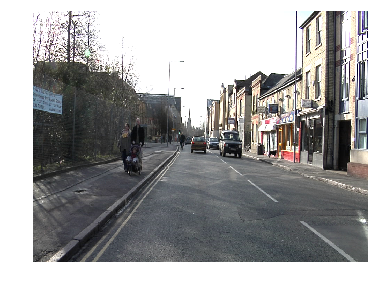

In [0]:
image_file = filenames[0]
image = open_image(image_file)
image.show(figsize=(6,6))

ลองดูไฟล์ label โดยเขียนฟังก์ชัน ให้ดูใน path_labels และ เพิ่มตัว _P จากชื่อไฟล์รูป

In [0]:
get_y_fn = lambda x: path_labels/f'{x.stem}_P{x.suffix}'

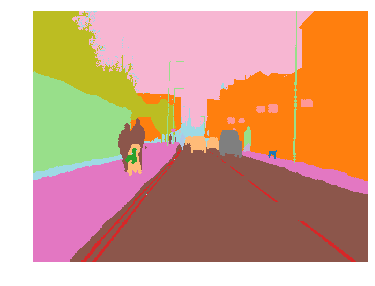

In [0]:
mask = open_mask(get_y_fn(image_file))
mask.show(figsize=(6,6), alpha=1)

label คือ รูปขนาด 960 x 720 Pixel เท่ารูปจริง แต่ละ Pixel คือรหัสว่าเป็นประเภทอะไร เช่น 26 = Tree (ต้นไม้), 19 = Sidewalk (ทางเท้า), 17 = Road (ถนน), 4 = Building (อาคาร) และ 21 = Sky (ท้องฟ้า) จาก codes ด้านล่าง

In [0]:
source_size = np.array(mask.shape[1:])
source_size, mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

ความหมายของทั้ง 32 หมวดหมู่ ใน Dataset

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
len(codes), codes

(32,
 array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
        'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
        'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
        'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17'))

# 3. เตรียมข้อมูล



เราจะเริ่มต้นเทรนโดยใช้รูปขนาดเล็กก่อน จะได้เทรนเร็ว 

* source_size ขนาดรูปจริงกว้างเท่าไร หาร 2 แล้วปัดเศษ //
* เนื่องจากรูปใหญ่หาร 2 แล้วก็ยังใหญ่อยู่ดี เราจึงต้องคำนวนหา [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) ที่เหมาะสม ไม่ใหญ่เกินจนทำให้ Out of Memory Error

In [0]:
size = source_size//2
bs = 0

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 16000: bs=16    
elif free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 0MB of GPU RAM free


ใช้ SegmentationItemList เป็น ItemList สำหรับทำ Segmentation โดยเฉพาะ ข้างในจะมี ImageList 2 ตัว บรรจุ images และ labels 

In [0]:
segmentitemlist = (SegmentationItemList.from_folder(path_images)
              .split_by_fname_file('../valid.txt')
              .label_from_func(get_y_fn, classes=codes))

สร้าง DataBunch tfm_y=True หมายความว่า Transform x อย่างไร ให้ทำ y ด้วย จะอธิบายในเรื่อง Data Augmentation ต่อไป

In [0]:
databunch = (segmentitemlist.transform(get_transforms(), 
                                  size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize(imagenet_stats))

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label 

label เป็นรูปเหมือนกัน จึงแสดงเป็นสี Overlay ซ้อนอยู่บนรูปจริง

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

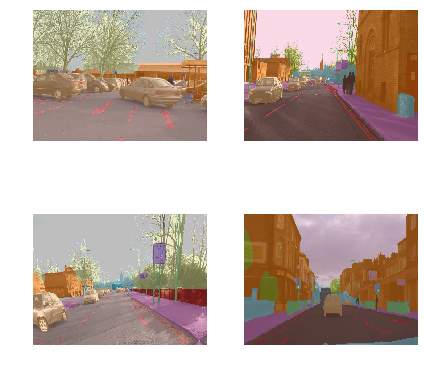

In [0]:
databunch.show_batch(2, figsize=(6, 6))

# 4. สร้างโมเดล



เนื่องจากในชุดข้อมูล label บางส่วนที่มีค่าเป็น Void จะไม่ถูกนำมาคำนวน [Accuracy](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) ทำให้เราต้องเขียนฟังก์ชันขึ้นมาใหม่ ชื่อ acc_camvid เพื่อ mask ส่วนดังกล่าวทิ้วไปก่อนคำนวน Accuracy

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

กำหนด Weight Decay เป็นหนึ่งในวิธี Regularization ไว้จะอธิบายต่อไป

In [0]:
wd=1e-2

สร้าง Learner เราจะใช้ Architecture ชื่อว่า U-Net แทนที่ CNN แบบปกติ 

*เรื่อง CNN, U-Net, ResNet, Autoencoder ไว้จะอธิบายต่อไป*

In [0]:
learner = unet_learner(databunch, models.resnet34, 
                       metrics=metrics, wd=wd, 
                       callback_fns=ShowGraph).to_fp16()

# 5. เริ่มต้นเทรนโมเดล



เทรนด้วยค่า Default ไป 10 Epoch

กำหนด pct_start ว่าจะให้ max_lr ที่ Iterations ไหน เป็นการทำเทรนด้วย One Cycle Policy ไว้เราจะอธิบายต่อไป

In [0]:
lr=3e-3

epoch,train_loss,valid_loss,acc_camvid,time
0,1.660292,1.056874,0.739370,01:16
1,1.177806,0.723859,0.821760,00:56
2,0.911625,0.609284,0.837404,00:56
3,0.768119,0.565814,0.849097,00:56
4,0.703856,0.577963,0.852442,00:56
5,0.664789,0.638390,0.831604,00:55
6,0.660371,0.487579,0.869859,00:55
7,0.608532,0.642884,0.835382,00:56
8,0.578485,0.451825,0.879948,00:56
9,0.535933,0.374200,0.892976,00:56


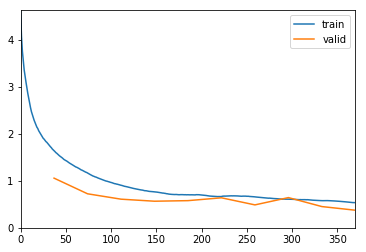

In [0]:
learner.fit_one_cycle(10, slice(lr), pct_start=0.9)

pct_start ทำให้ Learning Rate มีจุด Peek ที่ประมาณ 0.9 ของ Iteration ทั้งหมด

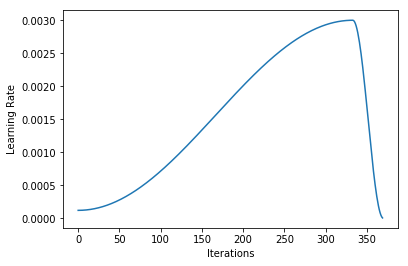

In [0]:
learner.recorder.plot_lr()

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [0]:
learner.save('unet-resnet34-1')

In [0]:
learner.load('unet-resnet34-1');

## ลองดูผลลัพธ์

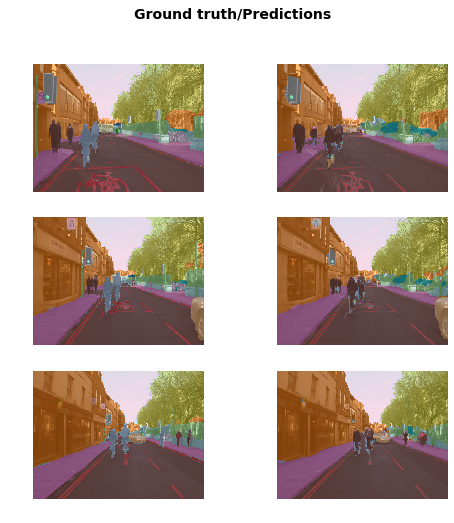

In [0]:
learner.show_results(rows=3, figsize=(8, 8))

# 6. เทรนต่อ

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

In [0]:
learner.unfreeze()

ลด [Learning Rate](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/) ลงมา 4 เท่า ไล่ไปถึง 400 เท่า สำหรับ Layer แรก ๆ 

In [0]:
lrs = slice(lr/400,lr/4)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.424979,0.362379,0.890861,00:58
1,0.420121,0.352387,0.894587,00:57
2,0.404762,0.348574,0.897642,00:57
3,0.391344,0.333566,0.905950,00:57
4,0.380693,0.342684,0.898901,00:57
5,0.371164,0.337834,0.901966,00:57
6,0.358748,0.329432,0.902465,00:57
7,0.343518,0.341403,0.897114,00:58
8,0.332139,0.337877,0.902080,00:57
9,0.321459,0.287988,0.918927,00:58


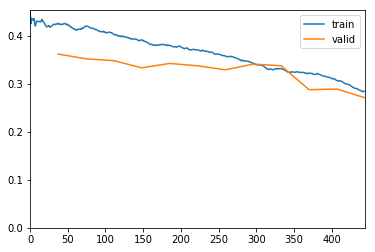

In [0]:
learner.fit_one_cycle(12, lrs, pct_start=0.8)

In [0]:
learner.save('unet-resnet34-2')

In [0]:
learner.load('unet-resnet34-2');

# 7. เทรนต่อ 2

[Transfer Learning](https://www.bualabs.com/archives/3493/what-is-transfer-learning-build-headless-mobilenet-model-transfer-learning-machine-learning-mobilenet-json-retrain-webcam-tensorflow-js-tfjs-ep-10/) ด้วยโมเดลของเราเอง ที่เพิ่งเทรนเสร็จ นำมาเทรนต่อด้วย 

1. size รูปใหญ่ขึ้น เป็น source_size 960 x 720 Pixel
2. [normalize](https://www.bualabs.com/archives/2100/what-is-normalization-feature-scaling-rescaling-normalization-standardization-feedforward-train-machine-learning-preprocessing-ep-2/) ด้วยข้อมูลใน Dataset ตัวเองแทนที่จะเป็น imagenet_stats ไว้เราจะอธิบายในเรื่อง Normalization ต่อไป
3. learner.destroy สั่งทำลาย Learner เก่า เพื่อเคลียร์ Memory

เนื่องจากรูป 960 x 720 ถือว่าใหญ่มาก เราจึงต้องคำนวนหา [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) ที่เหมาะสม ไม่ใหญ่เกินจนทำให้ Out of Memory Error

In [0]:
learner.destroy()

size = source_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 16000:  bs=8    
elif free > 8200: bs=4
else:             bs=2

print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=4, have 15641MB of GPU RAM free


In [0]:
databunch = (segmentitemlist.transform(get_transforms(), 
                                  size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize())

In [0]:
learner = unet_learner(databunch, models.resnet34, 
                       metrics=metrics, wd=wd, 
                      callback_fns=ShowGraph).to_fp16()


โหลด Weight ที่เราเพิ่งเทรนเสร็จขึ้นมาใหม่

Freeze ใหม่ เพื่อเทรนเฉพาะ Layer สุดท้าย แล้วเทรนไปอีก 10 Epoch

In [0]:
learner.load('unet-resnet34-2');
learner.to_fp16().freeze()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.371407,0.336766,0.905817,03:52
1,0.342071,0.323126,0.912930,03:54
2,0.327732,0.302595,0.919280,03:54
3,0.341860,0.324138,0.912199,03:54
4,0.341925,0.343308,0.901986,03:54
5,0.357368,0.323631,0.909521,03:54
6,0.347365,0.304011,0.921137,03:54
7,0.335236,0.283054,0.924515,03:55
8,0.287341,0.275106,0.927915,03:54
9,0.237815,0.254442,0.929311,03:54


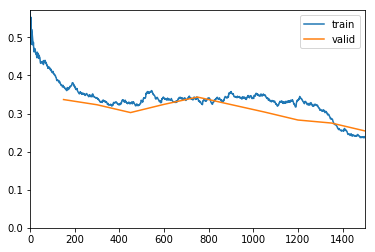

In [0]:
lr=1e-3
learner.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [0]:
learner.save('unet-resnet34-720-1')

In [0]:
learner.load('unet-resnet34-720-1');

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.218260,0.253045,0.930169,04:03
1,0.219032,0.255842,0.930197,04:02
2,0.219318,0.251820,0.931831,04:02
3,0.216721,0.255613,0.930949,04:03
4,0.200371,0.257663,0.931770,04:02
5,0.200880,0.246063,0.933605,04:02
6,0.194717,0.242857,0.934280,04:02
7,0.187059,0.257307,0.933559,04:02
8,0.189997,0.252566,0.934147,04:03
9,0.184030,0.254392,0.933969,04:02


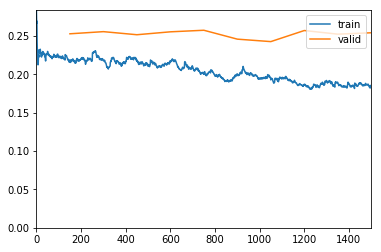

In [0]:
lrs = slice(1e-6,lr/10)
learner.fit_one_cycle(10, lrs)

## สำเร็จแล้ว

เราใช้เวลาในการเทรนไปเกือบ 2 ชั่วโมง ได้ Accuracy ที่ 0.934242 หรือ 93.4% เทียบกับใน Paper 91.5

In [0]:
learner.save('unet-resnet34-720-2')

In [0]:
learner.load('unet-resnet34-720-2');

# 8. ดูผลลัพธ์

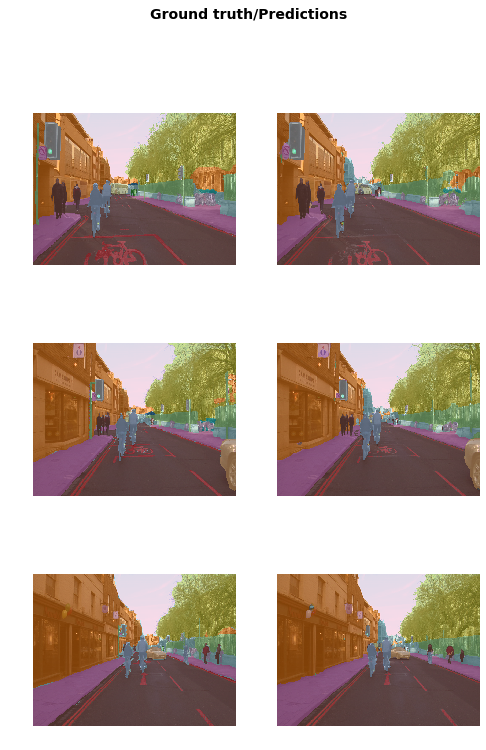

In [0]:
learner.show_results(rows=3, figsize=(8, 12))


# 9. สรุป


1. การเทรนโมเดลหลัก ๆ จะคล้าย ๆ กัน แต่ก็จะมีการทำ [Hyperparameter Tuning](https://www.bualabs.com/archives/tag/hyperparameter-tuning/) ตามแต่ละข้อมูล การเลือก [Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) U-Net ก็เป็นหนึ่งใน Hyperparameter Tuning 
2. เราสามารถสร้าง [Image Segmentation](https://www.bualabs.com/archives/tag/image-segmentation/) ได้ไม่ยาก แต่ที่ยากกว่าคือ หาชุดข้อมูล Dataset แบบนี้ต้อง label ด้วยมือ ทำให้เราสร้างชุดข้อมูลแบบนี้เองได้ค่อนข้างยาก ใช้ต้นทุนสูง
3. จะเห็นว่าโมเดลแบบนี้ มีประโยชน์มากขึ้นมากกว่า [Image Classification](https://www.bualabs.com/archives/530/machine-learning-ai-skin-disease-classification-custom-dataset-how-to-build-model-resnet50-deep-learning-python-image-classification-ep-4/) ที่เราเคยทำก่อนหน้านี้ โดยเฉพาะวงการการแพทย์ ที่ต้องวิเคราะห์ข้อมูลภาพเป็นจำนวนมาก ไม่ว่าจะเป็น X-Ray, MRI, CT-Scan

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 3](https://course.fast.ai/videos/?lesson=3)
* [Brostow et al., 2008](https://pdfs.semanticscholar.org/08f6/24f7ee5c3b05b1b604357fb1532241e208db.pdf) 
* [Finding Good Learning Rate and The One Cycle Policy.](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6)